### Deep Portfolio Optimization

Consider stock $S_t$ and bond $B_t$ and initial Wealth $V_0$. The wealth process is controlled by our trading strategy, equivalently speaking the proportion $\alpha_t$ of wealth $V_t$ we invest in stock, and the rest in bond. 
$$
\frac{dV_t}{V_t} = \alpha_t\frac{dS_t}{S_t} + (1-\alpha_t)\frac{dB_t}{B_t}.
$$
We aim at maximizing our expected utility i.e. 
$$
\max_{\alpha} \mathbb{E}[u(V_T)].
$$
For example, when $B_t$ is exponential and $S_t$ is exponential Brownian Motion
$$
\frac{dB_t}{B_t} = rdt, \quad  \frac{dS_t}{S_t} = \mu dt + \sigma dW_t,
$$
and $u$ be the log utility: $u(x) = \log(x)$. The the optimal $\alpha_t^{*} = \frac{\mu - r}{\sigma^2}$


In [3]:
%load_ext autoreload
%autoreload 2
import torch
from neuralhedge.data.stochastic import BlackScholesDataset, simulate_time
from neuralhedge.data.base import ManagerDataset
import matplotlib.pyplot as plt
import numpy as np 

from neuralhedge.nn.blackschole import BlackScholesAlpha
from neuralhedge.nn.datamanager import Manager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
n_sample = 1000
n_timestep = 64
dt = 1/12

mu = 0.1
sigma = 0.2
r = 0.01

def get_data(n_sample):
    ds_bs = BlackScholesDataset(n_sample = n_sample,
                            n_timestep = n_timestep,
                            dt = dt,
                            mu = mu,
                            sigma = sigma)
    stock = ds_bs.paths*100
    time = simulate_time(n_sample, dt, n_timestep, reverse = False)
    bond = torch.exp(r*time)*100
    paths = torch.cat([stock, bond], dim = -1)
    return paths 

Loss=-0.4746277630329132: 100%|██████████| 100/100 [00:36<00:00,  2.70it/s]

utility: 0.61


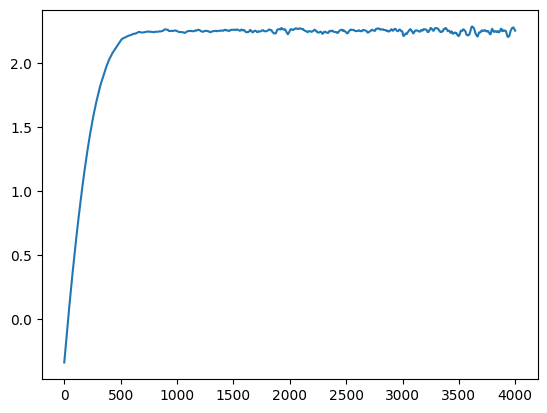

In [38]:
from neuralhedge.nn.loss import log_utility
from neuralhedge.nn.mlp import SingleWeight
n_trial = 1
real_small_alpha_list = []
check_convergence = True
for i in range(n_trial):
    real_data_small = get_data(n_sample)
    real_data_small_repeat = real_data_small.repeat(10,1,1)

    model = SingleWeight()
    manager = Manager(model)
    manager_ds = ManagerDataset([real_data_small_repeat,real_data_small_repeat])
    manager.fit(manager_ds,EPOCHS = 100, lr_scheduler_gamma = 0.999)

    with torch.no_grad():
        terminal_wealth = manager([real_data_small_repeat,real_data_small_repeat])[-1]   

    utility = log_utility(terminal_wealth).mean().numpy()

    real_small_alpha_list.append(manager.model.weight.item())
    print(f'utility: {utility:.2f}')
    if check_convergence: 
        plt.plot(manager.history['alpha'])
        plt.show()

In [10]:
real_small_alpha_list

[2.0772693157196045,
 2.1478419303894043,
 1.8853356838226318,
 2.3148932456970215,
 2.1630382537841797]

In [22]:
list(manager.parameters())[0].item()

2.1630382537841797

In [25]:
from collections import defaultdict
history = defaultdict(list)

In [35]:
history['loss'].append(1)

In [36]:
history['loss']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

The utility is 0.588


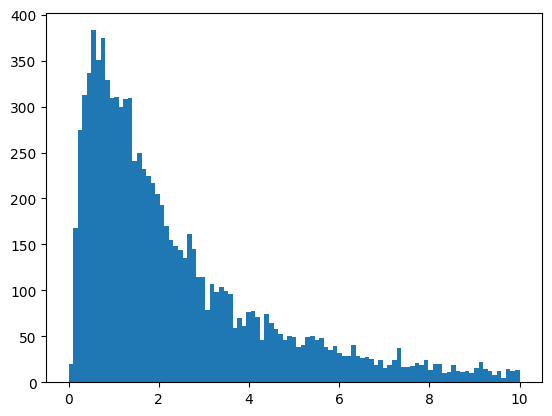

In [9]:
from neuralhedge.nn.loss import log_utility
paths = get_data()
model = BlackScholesAlpha(mu, sigma, r)
manager = Manager(model)
terminal_wealth = manager([paths,paths])[-1]
utility = log_utility(terminal_wealth).mean().numpy()
print('The utility is {:.3f}'.format(utility)) 
plt.hist(terminal_wealth, bins = list(np.linspace(0,10,100)))
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

Loss=-0.32367509603500366: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

The utility is 0.570


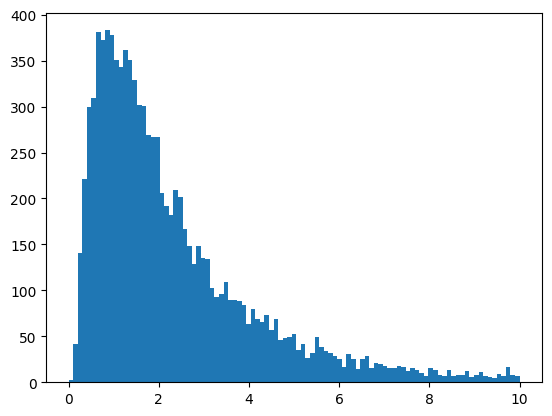

In [10]:
from neuralhedge.nn.mlp import SingleWeight
model = SingleWeight()
manager = Manager(model)
manager_ds = ManagerDataset([paths,paths])
manager.fit(manager_ds,EPOCHS = 20)
with torch.no_grad():
    terminal_wealth = manager([paths,paths])[-1]   
utility = log_utility(terminal_wealth).mean().numpy()
print('The utility is {:.3f}'.format(utility)) 
plt.hist(terminal_wealth, bins = list(np.linspace(0,10,100)))
plt.show()

In [11]:
print('The optimal ratio: {:.2f}'.format((mu-r)/sigma**2))
print('The learned ratio: {:.2f}'.format(model.weight.item()))

The optimal ratio: 2.25
The learned ratio: 1.82
